# Table of Contents
* [OCR experiment](#OCR-experiment)
* [End](#End)


# OCR experiment

This notebook compares the OCR results embedded in the textbook scans to those of eric's api, and MS oxford alone

bash curl -H "Content-Type: application/json" -X POST -d '{"url":" http://dgmde20.com/img/lorem-ipsum-2.png"}' http://dev-ocr.ai2:/v1/ocr

In [1]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import pprint
import pickle
import json
import requests
import io

In [3]:
import pdfextraction.ocr_pipeline

In [4]:
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image

In [10]:
def query_vision_ocr(image_url, merge_boxes=False, include_merged_components=False, as_json=True):
    api_entry_point = 'http://vision-ocr.dev.allenai.org/v1/ocr'
    header = {'Content-Type': 'application/json'}
    request_data = {
        'url': image_url,
        # 'maximumSizePixels': max_pix_size,
        'mergeBoxes': merge_boxes,
        'includeMergedComponents': include_merged_components
    }

    json_data = json.dumps(request_data)
    response = requests.post(api_entry_point, data=json_data, headers=header)
    print(response.content)
    json_response = json.loads(response.content.decode())
    if as_json:
        response = json_response
    return response

def form_image_url(book_name, page_n, ):
    book_name_no_ext = book_name.replace('.pdf', '_')
    image_base = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/page-images/'
    return image_base + book_name_no_ext + str(page_n) + '.jpeg'

In [8]:
test_page = form_image_url(book_breakdowns['daily_sci'][4], 153)
test_page

NameError: name 'form_image_url' is not defined

In [11]:
pagen = 10
test_page = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/Daily_Science_Grade_6_(Daily_Practice_Books)_Evan_Moor_'+str(pagen)+'.jpeg'
test_anno = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/unmerged_annotations/Daily_Science_Grade_6_(Daily_Practice_Books)_Evan_Moor_'+str(pagen) +'.json'
prev_anno = 'https://s3-us-west-2.amazonaws.com/ai2-vision-turk-data/textbook-annotation-test/annotations/Daily_Science_Grade_6_(Daily_Practice_Books)_Evan_Moor_'+str(pagen) +'.json'


ocr_res = json.loads(requests.get(test_anno).content)
ocr_res_prev = query_vision_ocr(test_page, merge_boxes= True)
ocr_res_prev_unmerged = query_vision_ocr(test_page, merge_boxes= False)

req = requests.get(test_page)
tpi = Image.open(io.BytesIO(req.content))

{"detections": [{"rectangle": [{"x": 1402, "y": 87}, {"x": 1486, "y": 125}], "value": "SCieo", "score": 1.0}, {"rectangle": [{"x": 178, "y": 1876}, {"x": 203, "y": 1901}], "value": "1.", "score": 1.0}, {"rectangle": [{"x": 177, "y": 1951}, {"x": 203, "y": 1977}], "value": "2.", "score": 1.0}, {"rectangle": [{"x": 1472, "y": 2056}, {"x": 1487, "y": 2078}], "value": "9", "score": 1.0}, {"rectangle": [{"x": 1306, "y": 76}, {"x": 1483, "y": 300}], "value": "Daily Sci Big Idea 1", "score": 0.75}, {"rectangle": [{"x": 85, "y": 125}, {"x": 158, "y": 150}], "value": "Name", "score": 1.0}, {"rectangle": [{"x": 119, "y": 182}, {"x": 964, "y": 351}], "value": "eekly Question Day Can horses and zebras have babies together?", "score": 0.75}, {"rectangle": [{"x": 82, "y": 417}, {"x": 1147, "y": 1018}], "value": "Horses are ideal animals for riding. They are tame, swift, and agile. They are also easy and comfortable to sit on because of the shape of their backs. But horses are delicate animals. They 

In [357]:
def display_page(raw_page_img, page_layout):
    page_png_stream, y_height = make_png_stream(raw_page_img)
    page_img = make_open_cv_img(page_png_stream)
    for box in page_layout._objs:
        lr, ul = get_bbox_tuple(box, y_height)
        try:
            # print box.get_text()
            pass
        except AttributeError:
            pass
        cv2.rectangle(page_img, ul, lr, color=random_color(), thickness=2)
    display(Image.fromarray(page_img, 'RGB'))


def draw_pdf_with_boxes(book_file, page_range, word_margin=0.1, line_overlap=0.5, char_margin=2.0,
                        line_margin=0.5, boxes_flow=0.5):
    if page_range:
        page_range = map(lambda x: x - 1, page_range)
        suffix = '[{}-{}]'.format(page_range[0], page_range[1])
        raw_multi_pdf = WImage(filename=book_file + suffix)
    else:
        raw_multi_pdf = WImage(filename=book_file)
        
    doc_page_layouts = make_page_layouts(book_file, page_range,
                                         line_overlap,
                                         char_margin,
                                         line_margin,
                                         word_margin,
                                         boxes_flow)
    page_images = raw_multi_pdf.sequence
    for page_n in range(len(page_images)):
        display_page(page_images[page_n], doc_page_layouts[page_n])

def random_color():
    import random
    return random.randint(0,255), random.randint(0,255), random.randint(0,255)

In [358]:
ocr_res

{u'figure': {},
 u'relationship': {},
 u'text': {u'T1': {u'box_id': u'T1',
   u'category': u'unlabeled',
   u'contents': u'SCieo',
   u'rectangle': [[1402, 87], [1486, 125]],
   u'score': 1.0,
   u'source': {u'$schema': u'http://json-schema.org/draft-04/schema',
    u'additionalProperties': False,
    u'properties': [{u'book_source': u'Daily_Science_Grade_6_(Daily_Practice_Books)_Evan_Moor'},
     {u'page_n': 10}],
    u'type': u'object'}},
  u'T10': {u'box_id': u'T10',
   u'category': u'unlabeled',
   u'contents': u'Idea 1',
   u'rectangle': [[1325, 264], [1474, 300]],
   u'score': 1.0,
   u'source': {u'$schema': u'http://json-schema.org/draft-04/schema',
    u'additionalProperties': False,
    u'properties': [{u'book_source': u'Daily_Science_Grade_6_(Daily_Practice_Books)_Evan_Moor'},
     {u'page_n': 10}],
    u'type': u'object'}},
  u'T11': {u'box_id': u'T11',
   u'category': u'unlabeled',
   u'contents': u'have babies together?',
   u'rectangle': [[283, 300], [957, 351]],
   u'sco

In [359]:
for boxn, box in ocr_res['text'].items():
    print(box['contents'])

1. agile
4. strong
WEEK 1
shape of their backs. But horses are delicate animals. They don't do
well in hot, dry conditions. And they are prone to catching certain
diseases.
Idea 1
have babies together?
Horses are ideal animals for riding. They are tame, swift, and
agile. They are also easy and comfortable to sit on because of the
zebra
A. Identify each trait as either physical or behavioral
behavioral, such as a horse's gentle nature
horse
Inherited traits may be physical, such as a zebra's stripes, or
offspring
are passed down
from parents to
Vocabulary
Zebras, on the other hand, are very strong. They are sturdy
eekly Question
Day Can horses and zebras
Name
Big
9
Daily Sci
1.
2.
SCieo
which are features that are passed down from parents to offspring
characteristics that
inherited traits
and tolerant of heat and drought. Also, they are more resistant to
disease. But zebras can't be easily tamed, and their body shape
in-HAIR-ih-tid
makes them difficult to ride
TRAYTZ
These characteristi

In [303]:
def make_annotation_json(box):
    def point_to_tuple(box):
        return tuple(OrderedDict(sorted(box.items())).values())

    def get_bbox_tuples(detection):
        return map(point_to_tuple, detection['rectangle'])

    ids = 1
    annotation = defaultdict(defaultdict)
    try:
        box_id = 'T' + str(ids)
        bounding_rectangle = get_bbox_tuples(box)
        annotation['text'][box_id] = {
            "box_id": box_id,
            "category": "unlabeled",
            "contents": box['value'],
            "score": box['score'],
            "rectangle": bounding_rectangle,
            "source": {
                "type": "object",
                "$schema": "http://json-schema.org/draft-04/schema",
                "additionalProperties": False,
                "properties": [
                    {"book_source": 't'},
                    {"page_n": 1}
                ]
            }
        }
        ids += 1
    except KeyError:
        return
        annotation['text'] = {}

    annotation['figure'] = {}
    annotation['relationship'] = {}
    return annotation['text'].values()[0]

In [682]:
%save merge.py 400 679

File `merge.py` exists. Overwrite (y/[N])?  y
The following commands were written to file `merge.py`:
class Detection:

    def __init__(self, start_x, start_y, end_x, end_y, value, score):
        self.start_x = start_x
        self.start_y = start_y
        self.end_x = end_x
        self.end_y = end_y
        self.value = value
        self.score = score

    def height(self):
        return self.end_y - self.start_y

    def width(self):
        return self.end_x - self.start_x

    def average_character_length(self):
        return (self.end_x - self.start_x)/float(len(self.value))

    def horizontal_near(self, other_detection):
        distance = abs(other_detection.start_x - self.end_x)
        from pprint import pprint

        return distance/other_detection.average_character_length() < 2.0



    def merge(self, other_detection):
        self.start_x = min(self.start_x, other_detection.start_x)
        self.start_y = min(self.start_y, other_detection.start_y)
        self.en

In [400]:
class Detection:

    def __init__(self, start_x, start_y, end_x, end_y, value, score):
        self.start_x = start_x
        self.start_y = start_y
        self.end_x = end_x
        self.end_y = end_y
        self.value = value
        self.score = score

    def height(self):
        return self.end_y - self.start_y

    def width(self):
        return self.end_x - self.start_x

    def average_character_length(self):
        return (self.end_x - self.start_x)/float(len(self.value))

    def horizontal_near(self, other_detection):
        distance = abs(other_detection.start_x - self.end_x)
        from pprint import pprint

        return distance/other_detection.average_character_length() < 2.0



    def merge(self, other_detection):
        self.start_x = min(self.start_x, other_detection.start_x)
        self.start_y = min(self.start_y, other_detection.start_y)
        self.end_x = max(self.end_x, other_detection.end_x)
        self.end_y = max(self.end_y, other_detection.end_y)
        self.value += " " + other_detection.value

    def to_JSON(self):
        return {
            'rectangle':[{'x':self.start_x, 'y':self.start_y}, {'x':self.end_x, 'y':self.end_y}],
            'value': self.value,
            'score': self.score}

    def __repr__(self):
        return json.dumps(self.to_JSON())


def det_json_to_obj(detections):
    return [Detection(det['rectangle'][0]['x'],det['rectangle'][0]['y'], det['rectangle'][1]['x'],det['rectangle'][1]['y'], det['value'], det['score']) for det in detections]

In [626]:
def merge_boxes_service_response(detections, threshold=1.0):
    rectangle_groups = []
    count = 0
    for current_d in detections:
        found_group = False
        for g in rectangle_groups:
            count += 1
            if not found_group:
                for d in g:
                    y_distance = min(abs(d.start_y - current_d.end_y), abs(current_d.start_y - d.end_y))
                    if y_distance < (d.height() * threshold) and current_d.start_x < d.end_x and current_d.end_x > d.start_x:
                        g.append(current_d)
                        found_group = True
                        break
        if not found_group:
            rectangle_groups.append([current_d])

    new_detections = []
    for g in rectangle_groups:
        if len(g) == 1:
            new_detections.append(g[0])
        else:
            min_x = min(map(lambda x: x.start_x, g))
            max_x = max(map(lambda x: x.end_x, g))
            min_y = min(map(lambda x: x.start_y, g))
            max_y = max(map(lambda x: x.end_y, g))
            words = ' '.join(map(lambda x: x.value, g))
            score = ' '.join(map(lambda x: str(x.score), g))
            detection = Detection(min_x, min_y, max_x, max_y, words, score)
            new_detections.append(detection)
    print(count)
    return new_detections

In [679]:
def start_x(box):
    return box['rectangle'][0][0]

def start_y(box):
    return box['rectangle'][0][1]

def end_x(box):
    return box['rectangle'][1][0]

def end_y(box):
    return box['rectangle'][1][1]

def height(box):
    return end_y(box) - start_y(box)

def width(box):
    return end_x(box) - start_x(box)

def get_value(box):
    return box['contents']

def get_score(box):
    return box['score']


def merge_boxes(detections, y_threshold=1.0, x_threshold=1.0):
    rectangle_groups = []
    count = 0 
    int_keys = {int(k[1:]):v for k,v in detections.items()}
    sdets = OrderedDict(sorted(int_keys.items()))
    for name, current_d in sdets.items():
        found_group = False
        for g in rectangle_groups:
            count +=1
            if not found_group:
                for d in g:
                    y_distance = min(abs(start_y(d) - end_y(current_d)), abs(start_y(current_d) - end_y(d)))
                    if y_distance < (height(d) * y_threshold) and start_x(current_d) < end_x(d) *x_threshold and end_x(current_d)*x_threshold > start_x(d):
                        g.append(current_d)
                        found_group = True
                        break
        if not found_group:
            rectangle_groups.append([current_d])

    new_detections = []
    for g in rectangle_groups:
        if len(g) == 1:
            new_detections.append(g[0])
        else:
            min_x = min(map(lambda x: start_x(x), g))
            max_x = max(map(lambda x: end_x(x), g))
            min_y = min(map(lambda x: start_y(x), g))
            max_y = max(map(lambda x: end_y(x), g))
            words = ' '.join(map(lambda x: get_value(x), g))
            score = ' '.join(map(lambda x: str(get_score(x)), g))
            detection = Detection(min_x, min_y, max_x, max_y, words, score)
            new_detection = make_annotation_json(detection.to_JSON())
            new_detections.append(new_detection)
    print(count)
    return new_detections

point_to_tuple = lambda box: tuple(box)
get_bbox_tuples = lambda detection: map(point_to_tuple, detection['rectangle'])

771


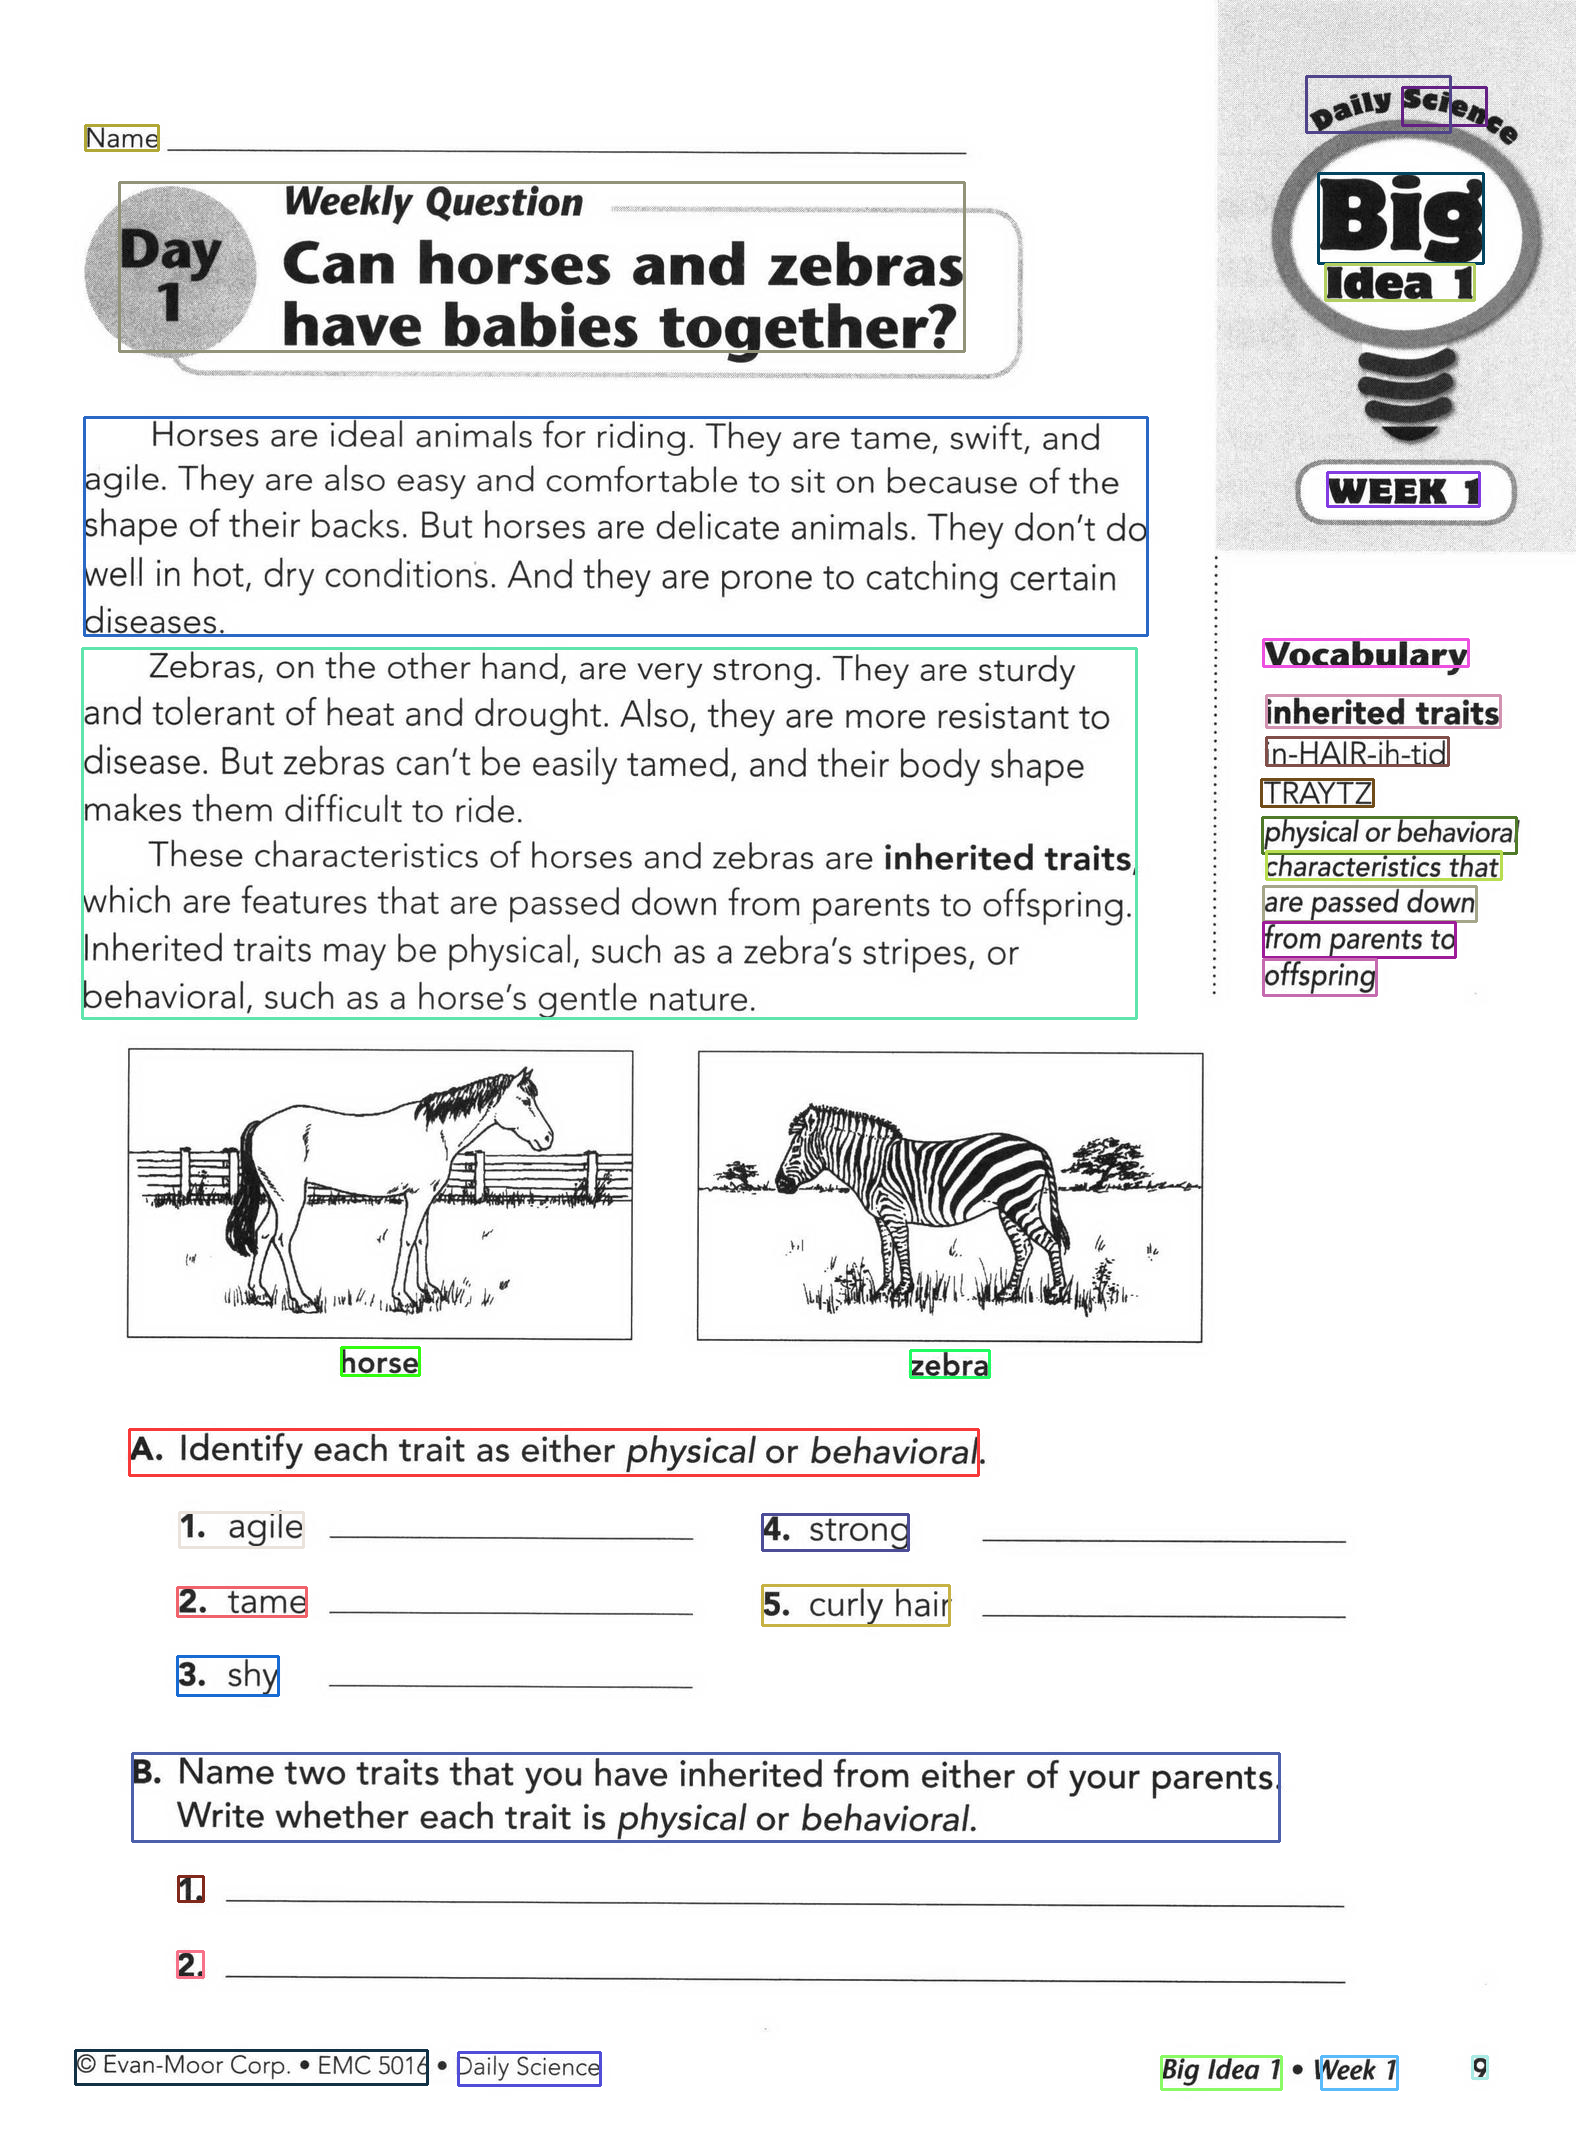

In [674]:
combined_boxes = merge_boxes(ocr_res['text'], 1.0, 0.4)

pil_image = tpi.convert('RGB') 
open_cv_image = np.array(pil_image) 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

point_to_tuple = lambda box: tuple(box)
get_bbox_tuples = lambda detection: map(point_to_tuple, detection['rectangle'])

for box in combined_boxes:
    lr, ul = tuple(get_bbox_tuples(box))
    cv2.rectangle(open_cv_image, ul, lr, color=random_color(), thickness=2)
display(Image.fromarray(open_cv_image, 'RGB'))

494


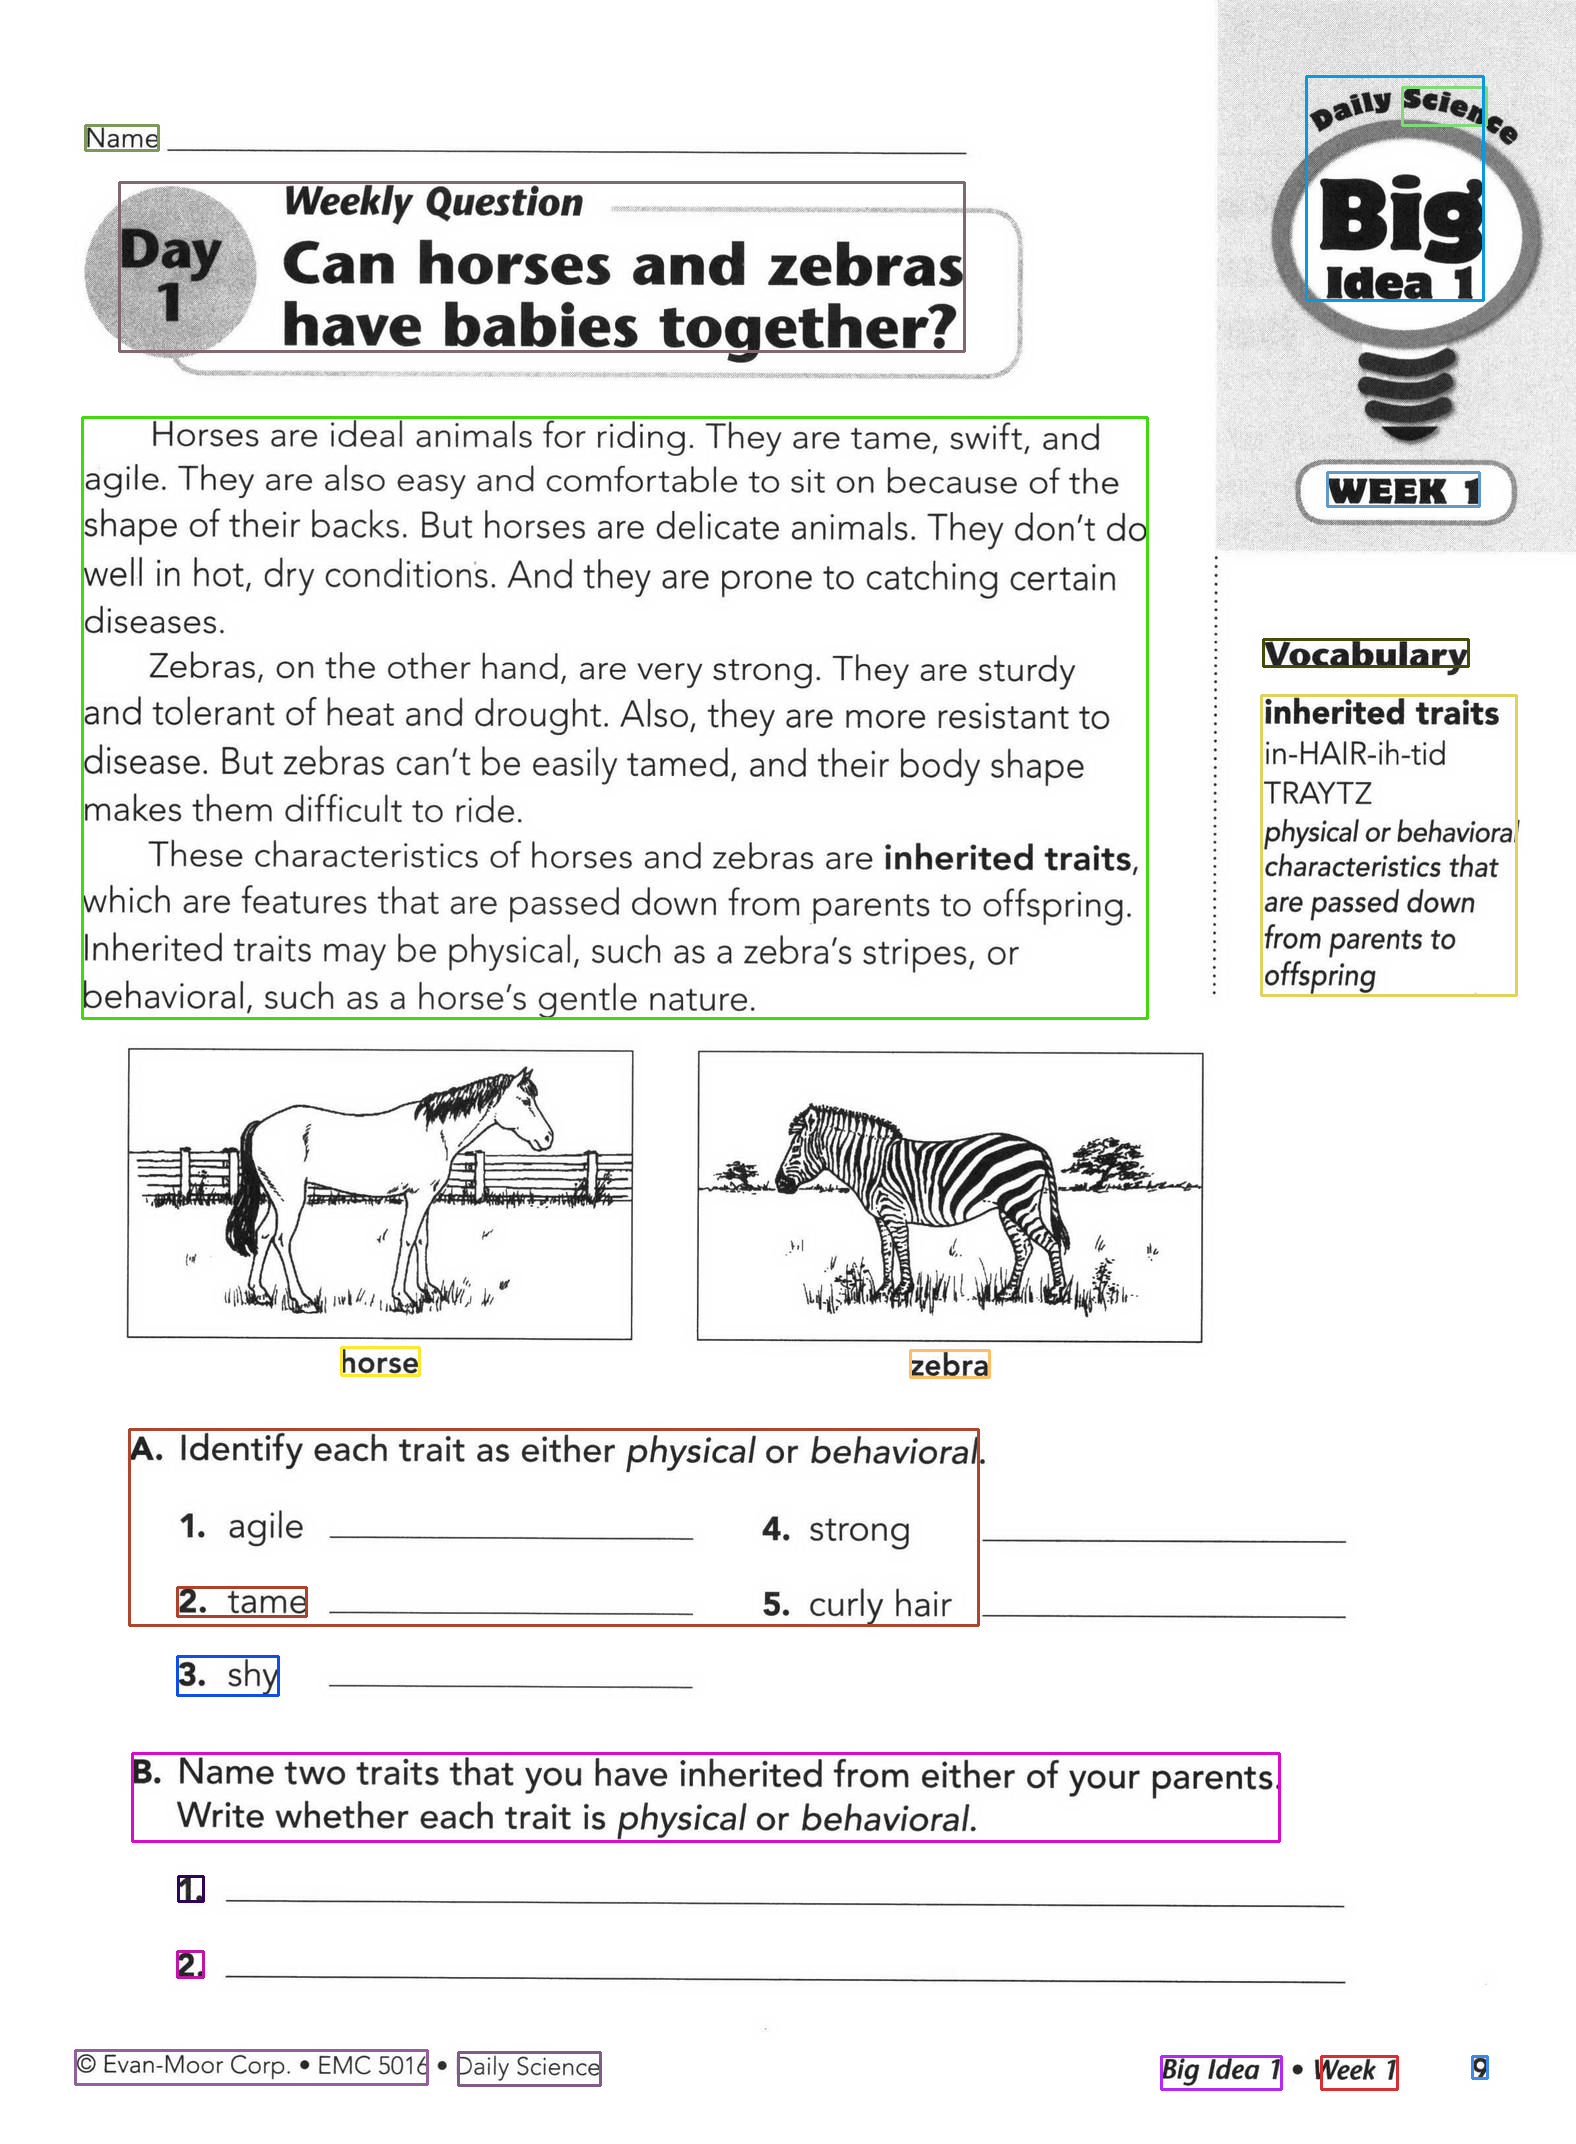

In [654]:
det_obj = det_json_to_obj(ocr_res_prev_unmerged['detections'])
merged_detections = merge_boxes_service_response(det_obj, 1)

pil_image = tpi.convert('RGB') 
open_cv_image = np.array(pil_image) 
open_cv_image = open_cv_image[:, :, ::-1].copy() 

def point_to_tuple(box):
    return tuple(OrderedDict(sorted(box.items())).values())

def get_bbox_tuples(detection):
    return map(point_to_tuple, detection['rectangle'])

for box in merged_detections:
    lr, ul = get_bbox_tuples(box.to_JSON())
    cv2.rectangle(open_cv_image, ul, lr, color=random_color(), thickness=2)
display(Image.fromarray(open_cv_image, 'RGB'))

In [45]:
# pil_image = tpi.convert('RGB') 
# open_cv_image = np.array(pil_image) 
# open_cv_image = open_cv_image[:, :, ::-1].copy() 

# def point_to_tuple(box):
#     return tuple(OrderedDict(sorted(box.items())).values())

# def get_bbox_tuples(detection):
#     return map(point_to_tuple, detection['rectangle'])

# for box in ocr_res_prev['detections']:
#     lr, ul = get_bbox_tuples(box)
#     cv2.rectangle(open_cv_image, ul, lr, color=random_color(), thickness=2)
# # display(Image.fromarray(open_cv_image, 'RGB'))

In [127]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

import glob
import pickle
import pdfextraction.merge as merging_tool
import pdfextraction.ocr_pipeline as ocp

In [128]:
def load_book_info():
    with open('./breakdowns.pkl', 'rb') as f:
        # book_breakdowns = pickle.load(f, encoding='latin1')
        book_breakdowns = pickle.load(f)

    with open('pdfs/page_ranges.csv') as f:
        ranges = f.readlines()
    range_lookup = {line.split(' ')[0]:[int(num) for num in line.strip().split(' ')[1:]] for line in ranges}
    return book_breakdowns, range_lookup

book_breakdowns, page_ranges = load_book_info()

In [140]:
merge_params = {
    'near_x': 3.0,
    'near_y': 2.0,
    'overlap_x': 0.8,
    'overlap_y': 0.6,
    'start_x': 1.0,
    'short_length': 1,
    'char_size_ratio': 0.4,
#     'overlap_fract': 0.4 # seems to work well
    'overlap_fract': 1.1 # turns off
}

dest_path = './ai2-vision-turk-data/textbook-annotation-test/merged-annotations/'
for textbook in book_breakdowns['daily_sci'][1:]:
    merging_tool.merge_single_book(textbook, page_ranges[textbook], dest_path, merge_params)

In [141]:
def load_local_annotation(page_name):
    base_path = '/Users/schwenk/wrk/notebooks/stb/ai2-vision-turk-data/textbook-annotation-test/unmerged-annotations/'
    file_path = base_path + page_name.replace('jpeg', 'json')
    with open(file_path, 'r') as f:
        local_annotations = json.load(f)
    return local_annotations

In [51]:
def process_annotation_results(img_dir, annotations_folder):
    for img in glob.glob(img_dir):
        img_name = img.rsplit('/')[-1]
        anno_file_name = img_name.replace('jpeg', 'json')
        try:
            existing_annotations = load_local_annotation(img_name)
            with open(img) as f:
                v_dim = ocp.record_image_size(f.read())[1]
            try:
                for box_name, box in existing_annotations['text'].items():
                    box['v_dim'] = v_dim
            except KeyError:
                print img
            file_path = annotations_folder + anno_file_name
            with open(file_path, 'wb') as f:
                json.dump(existing_annotations, f)
        except IOError:
            pass
#             print 'missing'
            

In [52]:
img_dir = './ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/*'
new_a_dir = './ai2-vision-turk-data/textbook-annotation-test/annotations_ws/'

In [53]:
process_annotation_results(img_dir, new_a_dir)

./ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/DK_Workbooks_Science_Second_Grade_DK_Publishing_64.jpeg
./ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/DK_Workbooks_Science_Third_Grade_DK_Publishing_64.jpeg
./ai2-vision-turk-data/textbook-annotation-test/smaller-page-images/Science_Essentials_Grades_3-4_School_Specialty_Publishing_163.jpeg


# End

In [120]:
def investigate_annotation_results(annotations_folder):
    for anno in glob.glob(annotations_folder):
        with open(anno, 'r') as f:
            local_annotations = json.load(f)
        try:
            for name, box in local_annotations['text'].iteritems():
                if box['source']['properties'][1]['page_n'] == '1':
                    print anno
        except KeyError:
#             pass
            print 'keyerror'

In [121]:
investigate_annotation_results(new_a_dir + '*')

keyerror
keyerror
keyerror
